In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC;
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn import preprocessing
import matplotlib.pyplot as plt

### Loading data

In [2]:
train = pd.read_csv('lab7_data.csv', sep='\t', decimal=',')
data, target = train.drop("churn",axis=1), train['churn']
(X_train, X_test, y_train, y_test) = train_test_split(data, target, test_size=0.2)

### ROC AUC

In [3]:
def roc_auc_curve(name, actual, predictions):
    print(name, roc_auc_score(actual, predictions))

    false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, c="#9C27B0", lw=2, label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def scale(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler.transform(X)

def find_best_parameters(classifier, parameters, apply_scaling=False, verbose=0):
    clf = GridSearchCV(classifier, 
                       parameters, 
                       cv=5, 
                       scoring='roc_auc',
                       verbose=verbose)
    X = X_train if not apply_scaling else scale(X_train)
    clf.fit(X, y_train)
    print(clf.best_params_)
    return clf.best_params_

## kNN

{'n_neighbors': 9}
kNN 0.5297293546148508


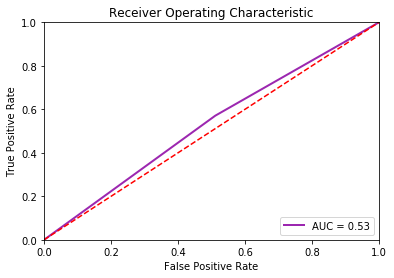

CPU times: user 8.92 s, sys: 87.8 ms, total: 9.01 s
Wall time: 9.15 s


In [4]:
%%time

def find_best_neighbors_param():
    params = find_best_parameters(KNeighborsClassifier(), {
        'n_neighbors': range(1, 15)
    })
    return params['n_neighbors']

knn = KNeighborsClassifier(n_neighbors=find_best_neighbors_param())
y_predicted = knn.fit(X_train, y_train).predict(X_test)
roc_auc_curve('kNN', y_test, y_predicted)

### Decision Tree

{'max_depth': 2, 'min_samples_split': 2}
Decision Tree 0.7963150589868147


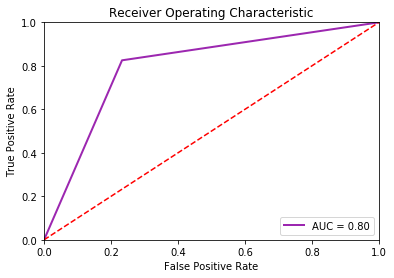

CPU times: user 16.4 s, sys: 50 ms, total: 16.5 s
Wall time: 17.8 s


In [5]:
%%time

def find_best_tree_params():
    params = find_best_parameters(DecisionTreeClassifier(), {
        'min_samples_split' : range(2, 10),
        'max_depth': range(2, 10)
    })
    return params['min_samples_split'], params['max_depth']

(min_samples_split, max_depth) = find_best_tree_params()
tree = DecisionTreeClassifier(min_samples_split=min_samples_split, max_depth=max_depth)
y_predicted = tree.fit(X_train, y_train).predict(X_test)
roc_auc_curve('Decision Tree', y_test, y_predicted)

### SVM

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=0.1, kernel=linear ............................................
[CV] ... C=0.1, kernel=linear, score=0.8165280665280664, total=   0.4s
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ... C=0.1, kernel=linear, score=0.8351091476091477, total=   0.4s
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] ... C=0.1, kernel=linear, score=0.8440748440748441, total=   0.4s
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


[CV] ... C=0.1, kernel=linear, score=0.8430386908647778, total=   0.4s
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s


[CV] ... C=0.1, kernel=linear, score=0.7751983736638468, total=   0.4s
[CV] C=1, kernel=linear ..............................................
[CV] ..... C=1, kernel=linear, score=0.8225268537768539, total=   2.1s
[CV] C=1, kernel=linear ..............................................
[CV] ..... C=1, kernel=linear, score=0.8384658697158697, total=   1.3s
[CV] C=1, kernel=linear ..............................................
[CV] ..... C=1, kernel=linear, score=0.8452442827442828, total=   1.6s
[CV] C=1, kernel=linear ..............................................
[CV] ..... C=1, kernel=linear, score=0.8385124254689471, total=   1.6s
[CV] C=1, kernel=linear ..............................................
[CV] ..... C=1, kernel=linear, score=0.7730780160447679, total=   1.4s
[CV] C=10, kernel=linear .............................................
[CV] .... C=10, kernel=linear, score=0.8209026334026335, total=  11.5s
[CV] C=10, kernel=linear .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.5min finished


{'C': 1, 'kernel': 'linear'}
SVC 0.5148577376821651


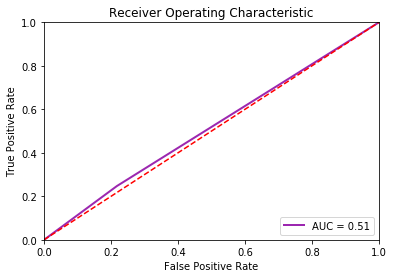

CPU times: user 1min 25s, sys: 292 ms, total: 1min 26s
Wall time: 1min 35s


In [6]:
%%time

def find_best_smv_params():
    params = find_best_parameters(SVC(), [
      {'C': [0.1, 1, 10], 'kernel': ['linear']},
      {'C': [0.1, 1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
     ], True, 5)
    return (params.get('C', None), params.get('kernel', None), params.get('gamma', None))

(c, kernel, gamma) = find_best_smv_params()
if gamma is None:
    svm = SVC(C=c, kernel=kernel)
else:
    svm = SVC(C=c, kernel=kernel, gamma=gamma)
    
y_predicted = svm.fit(scale(X_train), y_train).predict(X_test)
roc_auc_curve('SVC', y_test, y_predicted)